In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
sns.set(style="ticks", color_codes=True, font_scale=1.5)

In [2]:
pd.set_option('mode.chained_assignment', None)
sns.set_style('whitegrid')
plt.rcParams['font.size']=16

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one, _name_estimators
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from scipy import sparse

class FeatureUnion_pd(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
    
def make_union_pd(transformers):
    return FeatureUnion_pd(_name_estimators(transformers))

class ColumnsSelector_pd(BaseEstimator, TransformerMixin):
    # features must be a list
    def __init__(self, columns=None, reset_index=True, group=None):
        self.columns = columns
        self.reset_index = reset_index
        self.group = group
        
    def fit(self, X, y = None):
        if self.group == 'numeric':
            self._group_columns = X.select_dtypes(exclude=['object','category']).columns
        elif self.group == 'float':
            self._group_columns = X.select_dtypes(include='float64').columns
        elif self.group == 'int':
            self._group_columns = X.select_dtypes(include='int64').columns
        elif self.group == 'categorical':
            self._group_columns = X.select_dtypes(include=['object','category']).columns
        elif self.group == 'ordered categorical':
            self._group_columns = [col for col in X.select_dtypes(include='category')
                            if X.select_dtypes(include='category')[col].cat.ordered == True]
        elif self.group == 'unordered categorical':
            self._group_columns = [col for col in X.select_dtypes(include='category')
                            if X.select_dtypes(include='category')[col].cat.ordered == False]
        elif self.group == 'with NaN':
            self._group_columns = X.columns[X.isnull().any()]
        elif self.group == 'without NaN':
            self._group_columns = X.columns[~X.isnull().any()]
        elif self.group == 'exclude':
            self._group_columns = [col for col in X.columns if col not in self.columns]
        return self 
    
    def transform(self, X, y = None):
        df = X.copy()
        if self.reset_index:
            df.reset_index(drop=True, inplace=True)
        if self.group is None:
            return df[self.columns]
        else:
            return df[self._group_columns]
    
class drop_pd(BaseEstimator, TransformerMixin):
    def __init__(self, columns, reset_index=True):
        self.columns = columns
        self.reset_index = reset_index
        
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        df = X.drop(self.columns, axis=1)
        if self.reset_index:
            df.reset_index(drop=True, inplace=True)
        return df
    
class SimpleImputer_pd(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='most_frequent', missing_values=np.nan, fill_value=np.nan, add_indicator=True):
        self.strategy = strategy
        self.missing_values = missing_values
        self.fill_value = fill_value
        self.add_indicator = add_indicator
        self.transformer = SimpleImputer(missing_values=missing_values, strategy=strategy,
                                          fill_value=fill_value, add_indicator=add_indicator)
        
    def fit(self, X, y = None):
        self.transformer.fit(X)
        return self 
    
    def transform(self, X, y = None):
        transformer_output = self.transformer.transform(X)
        column_names = X.columns.tolist()
        if self.transformer.indicator_ is not None:
            for i in self.transformer.indicator_.features_:
                column_names.append(column_names[i] + '_missing')
        return pd.DataFrame(transformer_output, columns=column_names)
    
class OneHotEncoder_pd(BaseEstimator, TransformerMixin):
    def __init__(self, categories='auto', drop='first', sparse=False, handle_unknown='error', get_categories=True):
        self.categories = categories
        self.drop = drop
        self.sparse = sparse
        self.handle_unknown = handle_unknown
        self.get_categories = get_categories
        self.transformer = OneHotEncoder(categories=categories, drop=drop, sparse=sparse, handle_unknown=handle_unknown)

    def fit(self, X, y = None):
        if self.get_categories == True:
            categories = []
            for col in X.columns:
                categories.append(X[col].cat.categories.tolist())
            self.categories = categories
            self.transformer.categories = categories
        self.transformer.fit(X)
        return self 
    
    def transform(self, X, y = None):
        transformer_output = self.transformer.transform(X)
        original_columns = X.columns.tolist()
        final_columns = []
        for i, categories in enumerate(self.categories):
            if self.transformer.drop_idx_ is not None:
                categories = categories[1:]
            categories = [original_columns[i] + '_' + str(s) for s in categories]
            final_columns.extend(categories)
        return pd.DataFrame(transformer_output, columns=final_columns)

class OrdinalEncoder_pd(BaseEstimator, TransformerMixin):
    def __init__(self, categories='auto', get_categories=True):
        self.categories = categories
        self.get_categories = get_categories
        self.transformer = OrdinalEncoder(categories=categories)

    def fit(self, X, y = None):
        if self.get_categories == True:
            categories = []
            for col in X.columns:
                categories.append(X[col].cat.categories.tolist())
            self.categories = categories
            self.transformer.categories = categories
        self.transformer.fit(X)
        return self 
    
    def transform(self, X, y = None):
        transformer_output = self.transformer.transform(X)
        columns = X.columns.tolist()
        return pd.DataFrame(transformer_output, columns=columns)
    
class StandardScaler_pd(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True, with_std=True):
        self.with_mean = with_mean
        self.with_std = True
        self.transformer = StandardScaler(with_mean=with_mean, with_std=with_std)
        
    def fit(self, X, y = None):
        self.transformer.fit(X)
        return self 
    
    def transform(self, X, y = None):
        column_names = X.columns.tolist()
        transformer_output = self.transformer.transform(X)
        return pd.DataFrame(transformer_output, columns=column_names)
    
class MinMaxScaler_pd(BaseEstimator, TransformerMixin):
    def __init__(self, feature_range=(0, 1), copy=True):
        self.feature_range = feature_range
        self.copy = copy
        self.transformer = MinMaxScaler(feature_range=feature_range, copy=copy)
        
    def fit(self, X, y = None):
        self.transformer.fit(X)
        return self 
    
    def transform(self, X, y = None):
        column_names = X.columns.tolist()
        transformer_output = self.transformer.transform(X)
        return pd.DataFrame(transformer_output, columns=column_names)   

In [5]:
def missing_values(df):
    '''Shows percentage of missing values'''
    
    # Get only columns with missing values
    nan_df = df.loc[:,df.isnull().any()]
    # Get Series of the percentages and counts of missing data in descending order
    percent = nan_df.isnull().mean()*100
    count = nan_df.isnull().sum()
    # Return DataFrame of the Series (more visually appealing)
    df = pd.concat([count.rename('Count'), percent.rename('Fraction (%)').round(1).astype(str)+' %'], axis=1)
    return df.sort_values('Count', ascending=False)

# Import data from data_description.txt file

In [6]:
import re

def data_description_parser(ddFileName):
    categories_dict = {}
    with open(ddFileName, 'r') as f:
        lines = f.readlines()
        ln = 0
        while True:
            line = lines[ln]
            firstWord = line.split(' ', 1)[0]

            if ':' in firstWord and ':' not in lines[ln+2].split(' ', 1)[0]:  # if first word has : and it has categories
                categories = []
                descriptions = []
                ln += 2

                while re.search('[^ \t\n]', lines[ln]):
                    # Remove left white spaces, rigth \n and tabs and split at first tab
                    [category , description] = lines[ln].lstrip().rstrip('\n').rstrip('\t').split('\t', 1)
                    category = category.rstrip()
                    categories.append(category)
                    descriptions.append(description)

                    if ln == len(lines)-1:
                        break
                    ln +=1
                if all(map(lambda x: x.isdigit(), categories)):
                    categories = sorted(list(map(int, categories)))
                else:
                    categories.reverse()
                categories_dict[firstWord[:-1]] = categories

            if ln == len(lines)-1:
                break
            ln += 1
    
    return categories_dict

def import_data_description(ddFileName, datasets):
    
    categories_dict = data_description_parser(ddFileName)
    missmatches = {}
    for feature in categories_dict.keys():
        for data in datasets:
            for category in data[feature].unique().tolist():
                if category is not np.nan and category not in categories_dict[feature]:
                    if feature not in missmatches.keys():
                        missmatches[feature] = [category]
                    elif category not in missmatches[feature]:
                        missmatches[feature].append(category)
    
    if bool(missmatches):
        print('Warning: the following categories are not contained in the data description file\n')
        for feature, categories in missmatches.items():
            print(feature+':',end=' ')
            for category in categories:
                if category == categories[-1]:
                    print(category)
                else:
                    print(category, end=', ')
    else:
        print('All categories in the dataset are contained in the data description file')
    
    return categories_dict

# Import and create a copy of the dataset

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_prep = train.copy()
categories_dict = import_data_description('data_description.txt', [train,test])
pred = 'SalePrice'

All categories in the dataset are contained in the data description file


# First look at the dataset

In [10]:
# print(train_prep.info())
train_prep.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Explore the data

### Replacing NaNs that are independent categories

In [11]:
NaNToMissing = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                'FireplaceQu','GarageFinish','GarageQual','GarageCond','PoolQC','Fence',
                'Alley','GarageType'
               ]

train_prep.loc[:,NaNToMissing] = train_prep.loc[:,NaNToMissing].fillna('NA')

### Defining categorical features

In [12]:
from pandas.api.types import CategoricalDtype

orderedCatFeatures = ['OverallQual', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond',
                   'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                   'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual',
                   'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

for col, categories in categories_dict.items():
    if col in orderedCatFeatures:
        train_prep[col] = train_prep[col].astype(CategoricalDtype(categories=categories, ordered=True))
    else:
        train_prep[col] = train_prep[col].astype(CategoricalDtype(categories=categories, ordered=False))

In [13]:
sns.reset_defaults()
with sns.axes_style("white"):
    ax = data_cleaning.fit_transform(train).corr()[pred].sort_values().plot.bar()
    ax.yaxis.grid(True)
    sns.despine(left=True, bottom=True)
    plt.gcf().set_size_inches(16,5)

NameError: name 'data_cleaning' is not defined

In [ ]:
# sns.set_palette(sns.color_palette("Blues"))
sns.set_palette(sns.color_palette("Blues", n_colors=10))
sns.catplot(kind='box', x='OverallQual', y=pred, data=data_cleaning.fit_transform(train))
plt.gcf().set_size_inches(16,8)
# sns.set_palette(sns.color_palette("Blues", n_colors=10))

In [ ]:
data_cleaning.fit_transform(train).select_dtypes(include='category').columns

In [ ]:
possible_cat_int = data_cleaning.fit_transform(train).select_dtypes(include='int64')

cat_int_cols = [col for col in cat_int if len(cat_int[col].unique()) < 20]

data_cleaning.fit_transform(train)[cat_int_cols].apply(lambda x: [sorted(x.unique())])

In [ ]:
cat_int_cols.remove('PoolArea')
print(cat_int_cols)
cat_int_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold']

In [ ]:
train_prep.drop(['Id','YearRemodAdd','YearBuilt','YrSold','GarageYrBlt','MiscFeature'], axis=1, inplace=True)

In [ ]:
train_prep['AgeRemodAdd'] = pd.Timestamp('now').year - train['YearRemodAdd']
train_prep['AgeBuilding'] = pd.Timestamp('now').year - train['YearBuilt']
train_prep['TimeSold'] = pd.to_datetime(train['YrSold'].astype(str)+ '-' + train['MoSold'].astype(str), format='%Y-%m')
train_prep['AgeSold'] = (pd.Timestamp('now') - train_prep['TimeSold']).dt.days
train_prep['AgeGarage'] = pd.Timestamp('now').year - train['GarageYrBlt']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

variance = MinMaxScaler_pd().fit_transform(
    data_cleaning.fit_transform(train).select_dtypes(exclude='category')).var().sort_values(ascending=False)
variance.plot.bar(figsize=(16,6))
sns.despine()

In [ ]:
variance.loc[:'TotRmsAbvGrd'].index.tolist()

In [ ]:
mask = np.zeros_like(train_prep.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_prep.corr(), vmax=1, vmin=-1, cmap='bwr', mask=mask, xticklabels=True, yticklabels=True)
plt.gcf().set_size_inches(16,10)

In [ ]:
train_prep.select_dtypes(include='category').columns

In [ ]:
train_prep[['LotFrontage','SalePrice']].plot(kind='scatter', x='LotFrontage', y='SalePrice')

In [ ]:
ax = train_prep.hist(column='LotFrontage', bins=20)
ax[0,0].axvline(train_prep['LotFrontage'].mean(), c='red', ls='--', zorder=100, label='mean')
ax[0,0].axvline(train_prep['LotFrontage'].median(), c='lime', ls='-.', zorder=100, label='median')
ax[0,0].legend()

In [ ]:
ax = train_prep.hist(column='SalePrice', bins=20)
ax[0,0].axvline(train_prep['SalePrice'].mean(), c='red', ls='--', zorder=100, label='mean')
ax[0,0].axvline(train_prep['SalePrice'].median(), c='lime', ls='-.', zorder=100, label='median')
ax[0,0].legend()

# Custom transformers

In [211]:
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.api.types import CategoricalDtype

class define_categories(BaseEstimator, TransformerMixin):
    '''Defining categories for all the categorical features based on new_categories_dict'''
    
    def __init__(self, categories_dict=None, ordered_cat_features=None, combine_lowfreq_cats=True, threshold=10):
        self.combine_lowfreq_cats = combine_lowfreq_cats
        self.categories_dict = categories_dict
        self.ordered_cat_features = ordered_cat_features
        self.threshold = threshold
            
    def fit(self, X, y = None):
        self._cats_to_combine_dict = {}
        # Remove features that are not in the dataset from the dictionary
        columns = X.columns.tolist()
        self._new_categories_dict = self.categories_dict.copy()
        keys_to_delete = [feature for feature in self._new_categories_dict.keys() if feature not in columns]
        for key in keys_to_delete:
            del self._new_categories_dict[key]
        self._new_ordered_cat_features = self.ordered_cat_features.copy()
        self._new_ordered_cat_features = [feature for feature in self._new_ordered_cat_features if feature in columns]
        self._unordered_cat_features = [feature for feature in self._new_categories_dict.keys()
                               if feature not in self._new_ordered_cat_features]
        # All unordered categories have to be strings
        for feature in self._unordered_cat_features:
            self._new_categories_dict[feature] = list(map(str,self._new_categories_dict[feature]))
        if self.combine_lowfreq_cats:
            # Combine categories with low frequency
            for feature in self._unordered_cat_features:
                s = X[feature].astype(str).value_counts()
                
                # Check if the feature is too unbalanced
                if s[1:].sum() <= self.threshold:
                    print(s)
                    raise Exception('The feature "{}" is too unbalanced:\n{}'.format(feature, s))
                    
                # If the combination of all low frequency features is not enough for a new feature
                if not s[s<=self.threshold].empty and s[s<=self.threshold].sum() <= self.threshold:
                    # Combine them all with the next lowest frequency feature
                    cats_to_combine = s[(s[s>self.threshold].index[-1]):].index.tolist()
                else:
                    cats_to_combine = s[s<=self.threshold].index.tolist()
                
                # Append features that didn't appear in the dataset but still exists according to categories_dict
                extra_cats = [cat for cat in self._new_categories_dict[feature] if cat not in s.index.tolist()]
                if not cats_to_combine and extra_cats:
                    cats_to_combine.append(s.index[-1])                
                cats_to_combine.extend(extra_cats)
                
                if cats_to_combine:                       
                    # Add the categories to combine to the dictionary
                    self._cats_to_combine_dict[feature] = cats_to_combine

                    # Make a new category and apply it to the corresponding old categories
                    new_cat = '-'.join(cats_to_combine) + '_combined'
                    self._new_categories_dict[feature] = [cat for cat in s.index if cat not in cats_to_combine] + [new_cat]
                
        return self
    
    def transform(self, X, y = None):
        df = X.copy()
        for feature, cats_to_combine in self._cats_to_combine_dict.items():
            if df[feature].dtype == 'int64' or df[feature].dtype == 'float64':
                df[feature] = df[feature].astype(str)
                
            # Make a new category and apply it to the corresponding old categories
            new_cat = '-'.join(cats_to_combine)+'_combined'
            df.loc[df[feature].isin(cats_to_combine), feature] = new_cat

        for col, categories in self._new_categories_dict.items():
            if col in self._new_ordered_cat_features:
                df[col] = df[col].astype(CategoricalDtype(categories=categories, ordered=True))                
            else:
                df[col] = df[col].astype(CategoricalDtype(categories=categories, ordered=False))

        return df

class year_to_age(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        df = X.copy()
        # Tranforming time features to age features
        df['AgeRemodAdd'] = pd.Timestamp('now').year - train['YearRemodAdd']
        df['AgeBuilding'] = pd.Timestamp('now').year - train['YearBuilt']
        df['TimeSold'] = pd.to_datetime(train['YrSold'].astype(str)+ '-' + train['MoSold'].astype(str), format='%Y-%m')
        df['AgeSold'] = (pd.Timestamp('now') - df['TimeSold']).dt.days
        df['AgeGarage'] = pd.Timestamp('now').year - train['GarageYrBlt']
        df.drop('TimeSold', axis=1, inplace=True)
        
        return df
    
class nan_to_NA(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None):
        self.columns = columns
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        df = X.copy()
        df[self.columns] = df[self.columns].fillna(value='NA')        
        return df

# Imputation pipeline

In [212]:
from sklearn.pipeline import Pipeline, make_pipeline

imputation_pipes = [
    make_pipeline(
        ColumnsSelector_pd(['BsmtFullBath','BsmtHalfBath','GarageCars']),
        SimpleImputer_pd(strategy='median', add_indicator=False)
    ),
    make_pipeline(
        ColumnsSelector_pd(['LotFrontage']),
        SimpleImputer_pd(strategy='median', add_indicator=True)
    ),
    make_pipeline(
        ColumnsSelector_pd(['AgeGarage']),
        SimpleImputer_pd(strategy='constant', fill_value=year_to_age().fit_transform(train)['AgeGarage'].max(),
                         add_indicator=False)
    ),
    make_pipeline(
        ColumnsSelector_pd(['MasVnrArea']),
        SimpleImputer_pd(strategy='constant', fill_value=0, add_indicator=False)
    ),
    make_pipeline(
        ColumnsSelector_pd(['MasVnrType','MSZoning','Electrical','SaleType','KitchenQual','Exterior2nd','Exterior1st','Functional']),
        SimpleImputer_pd(strategy='most_frequent', add_indicator=False)
    ),
    make_pipeline(
        ColumnsSelector_pd(['BsmtFinSF2','BsmtFinSF1','BsmtUnfSF','GarageArea','TotalBsmtSF']),
        SimpleImputer_pd(strategy='mean', add_indicator=False))
]

# Preprocessing pipelines

In [225]:
categories_dict = data_description_parser('data_description.txt')

ordered_cat_features = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond',
                        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                        'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual',
                        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'OverallQual', 'OverallCond']

cols_to_drop = ['Id','YearRemodAdd','YearBuilt','YrSold','GarageYrBlt','MiscFeature','Street','Utilities']

cols_to_impute = ['LotFrontage','BsmtFullBath','BsmtHalfBath','GarageCars','AgeGarage','MasVnrArea',
                  'MasVnrType','MSZoning','Electrical','SaleType','KitchenQual','Exterior2nd','Exterior1st',
                  'BsmtFinSF2','BsmtFinSF1','BsmtUnfSF','GarageArea','TotalBsmtSF','Functional']

nan_to_NA_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageFinish',
           'GarageQual','GarageCond','PoolQC','Fence','Alley','GarageType']

data_cleaning = make_pipeline(
    nan_to_NA(columns=nan_to_NA_cols),
    year_to_age(),
    drop_pd(cols_to_drop),
    define_categories(categories_dict, ordered_cat_features, threshold=10))

imputation = make_union_pd(
    imputation_pipes
    + [ColumnsSelector_pd(columns=cols_to_impute, group='exclude')]
)

encoding = make_union_pd([
    make_pipeline(
        ColumnsSelector_pd(group='unordered categorical'),
        OneHotEncoder_pd(get_categories=True)),
    make_pipeline(
        ColumnsSelector_pd(group='ordered categorical'),
        OrdinalEncoder_pd(get_categories=True)),
    ColumnsSelector_pd(group='numeric')
])

preprocessing = make_pipeline(imputation, encoding, StandardScaler_pd())

In [134]:
df = cleaner.fit_transform(train)
for col in df.select_dtypes(include=['object','category']):
    if col not in ordered_cat_features:
        print(col)
        print(df[col].value_counts())
        print(categories_dict[col], end='\n\n')

Alley
NA                  1369
Grvl                  50
Pave-NA_combined      41
Name: Alley, dtype: int64
['NA', 'Pave', 'Grvl']

GarageType
Attchd                        870
Detchd                        387
BuiltIn                        88
NA                             81
Basment                        19
CarPort-2Types-NA_combined     15
Name: GarageType, dtype: int64
['NA', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types']

MasVnrType
None                          872
BrkFace                       445
Stone                         128
BrkCmn-nan-CBlock_combined     15
Name: MasVnrType, dtype: int64
['Stone', 'None', 'CBlock', 'BrkFace', 'BrkCmn']

MSZoning
RL                            1151
RM                             218
FV                              65
RH-C (all)-RP-I-A_combined      26
Name: MSZoning, dtype: int64
['RM', 'RP', 'RL', 'RH', 'I', 'FV', 'C (all)', 'A']

Electrical
SBrkr                           1335
FuseA                             94
FuseF-Fu

In [64]:
missing_values(test)

,Count,Fraction (%)
PoolQC,1456,99.8 %
MiscFeature,1408,96.5 %
Alley,1352,92.7 %
Fence,1169,80.1 %
FireplaceQu,730,50.0 %
LotFrontage,227,15.6 %
GarageCond,78,5.3 %
GarageYrBlt,78,5.3 %
GarageQual,78,5.3 %
GarageFinish,78,5.3 %


In [1409]:
print(ColumnsSelector_pd(group='unordered categorical').fit_transform(preprocessing.fit(
    train.drop(pred, axis=1)).transform(test)).columns.tolist())
print(ColumnsSelector_pd(group='unordered categorical').fit_transform(preprocessing.fit(
    train.drop(pred, axis=1)).transform(train)).columns.tolist())

LotConfig ['FR3', 'FR2']
LotConfig ['FR3', 'FR2']
['MSSubClass', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'Electrical', 'Electrical', 'SaleCondition']
LotConfig ['FR3', 'FR2']
LotConfig ['FR3', 'FR2']
['MSSubClass', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'Functional', 'SaleType', 'SaleCondition']


In [ ]:
p = preprocessing.fit(train.drop(pred, axis=1))
sorted(p.transform(train)['MSSubClass'].unique().tolist(), reverse=True)

# Models

In [226]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_prep = train.copy()
pred = 'SalePrice'

In [227]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

models = {}

models['Linear Regression'] = [
    make_pipeline(preprocessing, LinearRegression()),
    {}
]

# models['Logistic Regression'] = [
#     make_pipeline(preprocessing, LogisticRegression(solver='lbfgs')),
#     {
#         'logisticregression__C': np.linspace(0.1,2,20)
#     }
# ]

In [228]:
from sklearn.model_selection import train_test_split

clean_data = data_cleaning.fit_transform(train)
X = train.drop(pred, axis=1)
y = train[pred]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train = data_cleaning.fit_transform(X_train)
X_test = data_cleaning.transform(X_test)

# train_split = {}
# train_split['X_train'] = X_train
# train_split['X_test'] = X_test
# train_split['y_train'] = y_train
# train_split['y_test'] = y_test

In [231]:
lr = make_pipeline(preprocessing, LinearRegression()).fit(X_train, y_train)
lr.predict(X_test)

array([2.15978158e+05, 1.99018094e+05, 9.98235907e+04, 9.10783415e+04,
       1.30576450e+05, 3.20064934e+05, 3.22180455e+05, 1.44259313e+05,
       2.06115858e+05, 2.45773157e+05, 1.91981486e+05, 3.92721104e+04,
       1.97194445e+05, 3.29167891e+05, 2.24459315e+05, 9.82911270e+04,
       1.01536944e+05, 1.17318325e+05, 2.79508863e+05, 1.03641752e+05,
       1.18454793e+05, 1.69036143e+05, 2.61751284e+05, 3.55220158e+05,
       8.19906571e+04, 2.27278380e+05, 1.31655369e+05, 1.73059238e+05,
       4.10671428e+05, 1.36211774e+05, 1.81641513e+05, 1.28006029e+05,
       1.29260966e+05, 6.51613933e+04, 1.59498588e+05, 3.60588741e+05,
       1.38822341e+05, 1.07148810e+05, 2.38290049e+05, 9.33735609e+04,
       1.31762740e+05, 1.43438784e+05, 1.02245932e+05, 1.14978184e+05,
       1.49338411e+05, 1.67308420e+05, 1.20585068e+05, 2.19110042e+05,
       2.29873128e+05, 2.72326917e+05, 8.46522960e+04, 2.92543555e+05,
       1.26354446e+05, 2.32284327e+05, 2.08113376e+05, 1.23740966e+05,
      

In [240]:
lr = make_pipeline(preprocessing, LinearRegression()).fit(X_train, y_train)
lr[-1].coef_

array([-7.49478248e+03, -1.65260373e+03,  5.57716616e+02, -4.14527504e+03,
       -1.65995156e+03, -8.45262829e+02, -1.12847477e+03, -6.07671034e+16,
       -3.54647846e+16, -2.94875000e+02,  2.88125000e+03,  3.53500000e+02,
       -1.02200000e+03,  1.19600000e+03,  2.30400000e+03, -1.57300000e+03,
        1.09587500e+03, -1.50500000e+03, -2.53550000e+03,  3.99512500e+03,
        4.50000000e+02,  1.30100000e+04, -8.39500000e+02, -7.61000000e+02,
        2.68100000e+03,  5.75625000e+03,  1.24725000e+03,  2.80000000e+02,
        5.96954688e+03,  4.20000000e+02, -1.16825000e+03, -1.49000000e+02,
        8.50000000e+02,  9.42350000e+03,  1.50600000e+03,  3.49500000e+03,
       -3.21500000e+03, -4.03000000e+02,  6.00000000e+00, -1.46500000e+03,
       -1.04025000e+03, -2.72200000e+03,  1.09350000e+03,  6.07671034e+16,
        3.54647846e+16,  1.69785000e+04, -6.03600000e+03, -5.29000000e+03,
       -2.78400000e+03, -3.15900000e+03, -5.46000000e+03,  2.13100000e+03,
       -1.87237500e+03,  

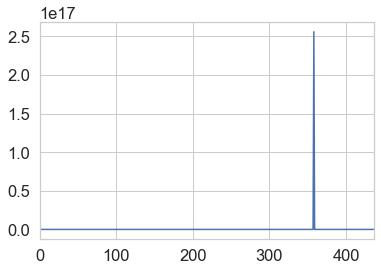

In [234]:
res = lr.predict(X_test) - y_test.reset_index(drop=True)
res.plot()

In [219]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

gs = {}
for model, [estimator, param_grid] in models.items():
    gs[model] = GridSearchCV(estimator, param_grid=param_grid, n_jobs=-2,
                             cv=RepeatedKFold(n_splits=3, n_repeats=10, random_state=1), iid=False, verbose=0)
    gs[model].fit(X_train, y_train)
    print('{} training score: {:.3f}'.format(model, gs[model].score(X_train, y_train)))
    print('{} test score: {:.3f}'.format(model, gs[model].score(X_test, y_test.reset_index(drop=True))))

Linear Regression training score: 0.872
Linear Regression test score: -20960806319345725603840.000


In [98]:
gs['Linear Regression'].predict(X_test)

array([ 2.15205600e+05,  1.98091411e+05,  9.98357150e+04,  9.08972746e+04,
        1.31359388e+05,  3.21461354e+05,  3.23594244e+05,  1.44597513e+05,
        2.07193727e+05,  2.43947600e+05,  1.93084337e+05,  4.03354983e+04,
        1.97267865e+05,  3.31597968e+05,  2.24764916e+05,  9.97095403e+04,
        1.01607584e+05,  1.17347486e+05,  2.80229518e+05,  1.02149154e+05,
        1.18679941e+05,  1.55676206e+05,  2.61928783e+05,  3.58664770e+05,
        8.26074703e+04,  2.27382938e+05,  1.33255727e+05,  1.72487443e+05,
        4.10634915e+05,  1.37038011e+05,  1.86086357e+05,  1.27909444e+05,
        1.30035226e+05,  4.94053994e+04,  1.59432755e+05,  3.63157530e+05,
        1.38824925e+05,  1.07519739e+05,  2.38312193e+05,  9.22896109e+04,
        1.31322269e+05,  1.43641174e+05,  1.02782224e+05,  1.15211933e+05,
        1.48798146e+05,  1.66966754e+05,  1.20955783e+05,  2.19951971e+05,
        2.29614539e+05,  2.72195872e+05,  8.54135638e+04,  2.93554878e+05,
        1.25434100e+05,  

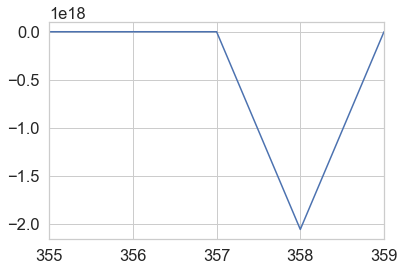

In [105]:
res = gs['Linear Regression'].predict(X_test) - y_test.reset_index(drop=True)
res[355:360].plot()

In [ ]:
from scipy.stats import chi2_contingency

y_feature = 'Embarked'
X_feature = 'SibSp'
X = train_prep[X_feature]
y = train_prep[y_feature]
chi, p, dof, E = chi2_contingency(pd.crosstab(X,y))
p

features_list = train_prep.select_dtypes(include=['object','category']).columns.tolist()
p_matrix = np.zeros((len(features_list), len(features_list)))

for i, y_feature in enumerate(features_list):
    y = train_prep[y_feature]
    for j, feature in enumerate(features_list):
        X = train_prep[feature]
        chi_stats = chi2_contingency(pd.crosstab(X,y))
        p_matrix[i,j] = chi_stats[1]

mask = np.zeros_like(p_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pd.DataFrame(p_matrix, index=features_list, columns=features_list), robust=True, cmap='Reds',
            fmt='.3f', annot=True, mask=mask)
plt.gcf().set_size_inches(12,8)

In [106]:
res[358]

-2.055044813794823e+18

In [99]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test.reset_index(drop=True), gs['Linear Regression'].predict(X_test))

4691883136540145.0

In [113]:
gs['Linear Regression'].predict(X_test)[358]

-2.05504481379473e+18

In [238]:
X_test.reset_index(drop=True).iloc[358].head(20)

MSSubClass           20
MSZoning             RM
LotFrontage          60
LotArea            6000
Alley              Pave
LotShape            Reg
LandContour         Bnk
LotConfig        Inside
LandSlope           Mod
Neighborhood    OldTown
Condition1         Norm
Condition2         Norm
BldgType         2fmCon
HouseStyle       1Story
OverallQual           4
OverallCond           4
RoofStyle         Gable
RoofMatl        CompShg
Exterior1st     MetalSd
Exterior2nd     MetalSd
Name: 358, dtype: object

In [132]:
gs['Linear Regression'].best_estimator_[-1].coef_

array([-7.36425508e+03, -1.73231594e+03,  4.84907672e+02, -4.04527422e+03,
       -1.77735015e+03, -8.90788322e+02, -9.42740458e+02, -1.36490187e+17,
        2.84655290e+17, -3.36000000e+02,  2.76200000e+03, -1.16400000e+03,
        3.89000000e+02,  1.22400000e+03,  2.38000000e+03, -1.33800000e+03,
        1.11600000e+03, -1.30200000e+03, -2.60900000e+03,  4.01000000e+03,
        4.39500000e+02,  1.33760000e+04, -8.12000000e+02, -6.88000000e+02,
        2.69200000e+03,  5.83200000e+03,  1.22600000e+03,  3.00000000e+02,
        5.98000000e+03,  4.20000000e+02, -1.19200000e+03, -1.36000000e+02,
        9.54000000e+02,  9.45600000e+03,  1.55100000e+03,  3.55400000e+03,
       -3.24400000e+03, -3.52000000e+02, -1.50000000e+01, -1.58800000e+03,
       -1.10300000e+03, -2.69800000e+03, -1.13540000e+04,  1.36490187e+17,
       -8.08000000e+03, -2.84655290e+17, -6.43200000e+03, -5.18400000e+03,
       -2.84400000e+03, -3.14400000e+03, -5.31200000e+03,  2.22000000e+03,
       -1.90400000e+03,  

In [158]:
pd.concat([X_train,y_train],axis=1).groupby(['BldgType']).mean()[pred]

BldgType
1Fam               181940.054608
TwnhsE             162439.465517
Duplex             201778.461538
Twnhs              233452.666667
2fmCon_combined    174114.285714
Name: SalePrice, dtype: float64

In [135]:
preprocessing.fit_transform(X_train).columns.tolist()[6:10]

['MSSubClass_160', 'MSSubClass_90', 'MSSubClass_190', 'MSSubClass_85']

In [153]:
coef = pd.Series(gs['Linear Regression'].best_estimator_[-1].coef_, index=preprocessing.fit_transform(X_train).columns.tolist())
coef.abs().sort_values(ascending=False).head(10)

BldgType_2fmCon_combined    2.846553e+17
MSSubClass_190              2.846553e+17
MSSubClass_90               1.364902e+17
BldgType_Duplex             1.364902e+17
GrLivArea                   1.093681e+17
2ndFlrSF                    8.983703e+16
1stFlrSF                    8.101410e+16
BsmtFinSF1                  7.753807e+16
TotalBsmtSF                 7.501419e+16
BsmtUnfSF                   7.340553e+16
dtype: float64

In [163]:
X_train.corr().columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'AgeRemodAdd', 'AgeBuilding', 'AgeSold', 'AgeGarage'],
      dtype='object')

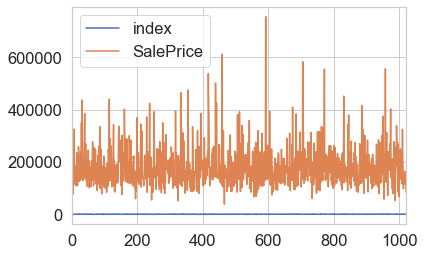

In [122]:
y_train.reset_index().plot()